Unique Destination Countries:
 New Zealand    3448
Nepal          3446
Egypt          3423
Colombia       3408
China          3391
Denmark        3375
Israel         3356
France         3346
Iceland        3344
Italy          3342
Canada         3331
Ireland        3316
Germany        3301
India          3291
Maldives       3265
Mexico         3257
Japan          3255
Brazil         3241
Kenya          3233
Iran           3172
Name: Destination_Country, dtype: int64


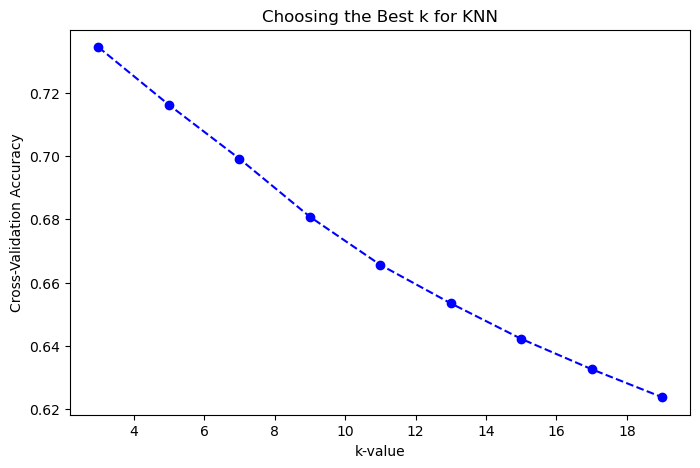

Best k-value: 3
Final Model Accuracy: 0.6357

Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.08      0.07       681
           1       0.05      0.06      0.06       685
           2       0.06      0.05      0.05       689
           3       0.06      0.04      0.04       690
           4       0.79      0.79      0.79     10564

    accuracy                           0.64     13309
   macro avg       0.20      0.20      0.20     13309
weighted avg       0.64      0.64      0.64     13309


Confusion Matrix:
 [[  55   50   30   15  531]
 [  52   42   36   27  528]
 [  44   40   35   15  555]
 [  40   44   37   26  543]
 [ 795  616  467  384 8302]]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE  # ✅ Import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Load the dataset
df = pd.read_csv("hoteldataset.csv", encoding="ISO-8859-1")  # Fixes encoding issues

# 2️⃣ Replace spaces in column names with underscores
df.columns = df.columns.str.strip().str.replace(" ", "_")

# 3️⃣ Print the unique values and frequency of 'Destination_Country'
print("Unique Destination Countries:\n", df["Destination_Country"].value_counts())

# 4️⃣ Categorize 'Destination_Country' into 4 groups based on frequency
top_countries = df["Destination_Country"].value_counts().index[:4]  # Top 4 most common
df["Destination_Country"] = df["Destination_Country"].apply(lambda x: x if x in top_countries else "Other")

# 5️⃣ Select Features (X) and Target (y)
X = df[['Gender', 'Age', 'Origin_Country', 'State', 'Hotel_Rating', 'No_of_Days', 'No_Of_People']]
y = df['Destination_Country']  # Categorized Destination Country

# 6️⃣ Convert categorical variables into numerical (One-Hot Encoding for Gender, Origin_Country, State)
X = pd.get_dummies(X, drop_first=True)

# 7️⃣ Split data into Training and Testing before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ 8️⃣ Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# ✅ 9️⃣ Normalize numerical features AFTER splitting to prevent data leakage
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# 🔟 Encode target variable
le = LabelEncoder()
y_train_balanced = le.fit_transform(y_train_balanced)
y_test = le.transform(y_test)

# 1️⃣1️⃣ Find the best k-value using cross-validation
k_values = list(range(3, 21, 2))  # ✅ Lower k-values to reduce bias
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_balanced, y_train_balanced, cv=5)
    accuracies.append(scores.mean())

# 1️⃣2️⃣ Plot k-value vs Accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='dashed', color='b')
plt.xlabel('k-value')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing the Best k for KNN')
plt.show()

# 1️⃣3️⃣ Train the model with the best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k-value: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_balanced, y_train_balanced)

# 1️⃣4️⃣ Evaluate the model
accuracy = knn.score(X_test, y_test)
print(f"Final Model Accuracy: {accuracy:.4f}")

# ✅ 1️⃣5️⃣ Print Classification Report & Confusion Matrix
y_pred = knn.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [2]:
import joblib

# Save the trained KNN model
joblib.dump(knn, 'knn_model.pkl')

# Save the scaler (since we need it for prediction)
joblib.dump(scaler, 'scaler.pkl')

print("KNN model and scaler saved successfully!")

KNN model and scaler saved successfully!


In [18]:
joblib.dump(X.columns.tolist(), 'expected_columns.pkl')

['expected_columns.pkl']

In [25]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
import threading

# Load the trained model and scaler
knn = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')

# Load the expected feature columns from training
expected_columns = joblib.load('expected_columns.pkl')  # Save this during training

# Define Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()  # Get JSON input
        df = pd.DataFrame([data])  # Convert input data to DataFrame

        # Apply same transformations as during training
        df = pd.get_dummies(df, drop_first=True)

        # **Fix: Add missing columns efficiently using pd.concat()**
        missing_cols = list(set(expected_columns) - set(df.columns))
        if missing_cols:
            missing_df = pd.DataFrame(0, index=df.index, columns=missing_cols)  # Create missing columns at once
            df = pd.concat([df, missing_df], axis=1)  # Combine

        # Ensure the column order matches the training data
        df = df[expected_columns]

        # Scale input features
        X_scaled = scaler.transform(df)

        # Make prediction
        prediction = knn.predict(X_scaled)

        return jsonify({'prediction': prediction.tolist()})

    except Exception as e:
        return jsonify({'error': str(e)})

# Function to run Flask in a separate thread
def run_flask():
    app.run(port=5000, debug=True, use_reloader=False)

# Start Flask in a background thread
thread = threading.Thread(target=run_flask)
thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


In [26]:
import requests

# Sample input data
input_data = {
    "Gender": "Male",
    "Age": 35,
    "Origin_Country": "Thailand",
    "State": "Bangkok",
    "Hotel_Rating": 4,
    "No_of_Days": 5,
    "No_Of_People": 2
}

# Send a POST request to the API
response = requests.post("http://127.0.0.1:5000/predict", json=input_data)

# Print the response
print(response.json())

C:\Users\iamhi\AppData\Local\Temp\ipykernel_6248\2093294687.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # Add missing columns with 0 value
C:\Users\iamhi\AppData\Local\Temp\ipykernel_6248\2093294687.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # Add missing columns with 0 value
C:\Users\iamhi\AppData\Local\Temp\ipykernel_6248\2093294687.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

127.0.0.1 - - [14/Mar/2025 20:58:03] "POST /predict HTTP/1.1" 200 -


{'prediction': [0]}


C:\Users\iamhi\AppData\Local\Temp\ipykernel_6248\2093294687.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # Add missing columns with 0 value
C:\Users\iamhi\AppData\Local\Temp\ipykernel_6248\2093294687.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0  # Add missing columns with 0 value
C:\Users\iamhi\AppData\Local\Temp\ipykernel_6248\2093294687.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

127.0.0.1 - - [14/Mar/2025 21:03:19] "POST /predict HTTP/1.1" 200 -


Missing Columns: {'State_Kemang', 'State_Kupang', 'State_Rantau Panjang', 'State_Santreae', 'State_Thai Nguyen', 'State_Sakon Nakhon', 'State_Kandal Stueng', 'State_Andong Teuk', 'State_Surakarta', 'State_Sawah Besar', 'State_Soreang', 'State_Tarlac', 'State_Tigi', 'State_Tak', 'State_Pouk', 'State_Laguna', 'State_Kelapa Dua', 'State_Senayan', 'State_Cilegon', 'State_Bien Hoa', 'State_Maguindanao', 'State_Central', 'State_Indramayu', 'State_Merdeka', 'State_Sultan Kudarat', 'State_Pleiku', 'State_Baray', 'State_West', 'State_Nueva Ecija', 'State_Bak Khlang', 'State_Pogar', 'State_Luwuk', 'State_Pangasinan', 'State_Santuk', 'State_Kebayoran', 'State_Pamanukan', 'State_Basilan', 'State_Hue', 'State_Suong', 'State_Prey Tralach', 'State_Udon Thani', 'State_Sari Rejo', 'State_Phnom Kravanh', 'State_Kedah', 'State_Sarawak', 'State_Angkor Borei', 'State_Kenyam', 'State_Bataan', 'State_My Tho', 'State_South Jakarta', 'State_Timika', 'State_Phuket', 'State_Rizal', 'State_Chiang Rai', 'State_Dou